  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)


Frecuencia de muestreo estimada: 18.52 Hz

🎯 Frecuencias detectadas para Péndulo 1:
 - 1.27 Hz (amplitud: 8.4017)

🎯 Frecuencias detectadas para Péndulo 2:
 - 0.83 Hz (amplitud: 0.8618)
 - 1.27 Hz (amplitud: 0.3075)

🎯 Frecuencias detectadas para Péndulo 3:

📁 Gráfico guardado como: 001_15_espectro.png


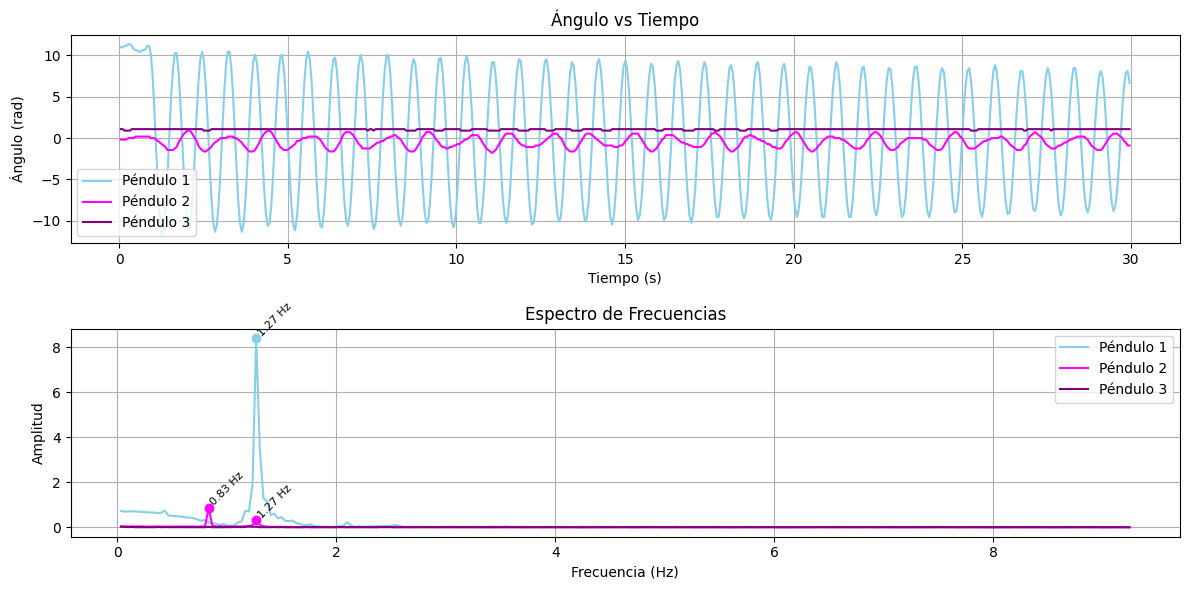

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os

# --- Parámetros de detección de picos ---
UMBRAL_ALTURA_RELATIVA = 0.1      # Porcentaje del pico máximo (10%)
PROMINENCE_MINIMA = 0.05          # Mínima prominencia del pico
DISTANCIA_MINIMA_PUNTOS = 5       # Separación mínima entre picos (en puntos de frecuencia)

def cargar_datos(ruta_archivo):
    with open(ruta_archivo, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    data_lines = [line for line in lines if not line.startswith('#')]
    temp_path = 'temp_data.tsv'
    with open(temp_path, 'w', encoding='utf-8') as f:
        f.writelines(data_lines)
    df = pd.read_csv(temp_path, sep='\t', engine='python')
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna()
    return df

def calcular_frecuencia_muestreo(tiempos):
    if len(tiempos) > 1:
        frecuencia = 1 / np.mean(np.diff(tiempos))
        print(f"Frecuencia de muestreo estimada: {frecuencia:.2f} Hz")
        return frecuencia
    else:
        print("No hay suficientes puntos de tiempo para estimar la frecuencia de muestreo.")
        return None

def aplicar_fft(senal, frecuencia_muestreo):
    N = len(senal)
    transformada = np.fft.fft(senal)
    amplitudes = np.abs(transformada)
    frecuencias = np.fft.fftfreq(N, d=1/frecuencia_muestreo)
    return frecuencias, amplitudes, N

def graficar_resultados(tiempo, angulos, espectros, nombre_archivo):
    nombres = ['1', '2', '3']
    colores = ['skyblue', 'magenta', 'purple']
    plt.figure(figsize=(12, 6))

    # Ángulo vs Tiempo
    plt.subplot(2, 1, 1)
    for i, angulo in enumerate(angulos):
        plt.plot(tiempo, angulo, label=f'Péndulo {nombres[i]}', color=colores[i])
    plt.title('Ángulo vs Tiempo')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Ángulo (rad)')
    plt.legend()
    plt.grid(True)

    # Espectro de frecuencias con picos
    plt.subplot(2, 1, 2)
    for i, (frec, amp, N) in enumerate(espectros):
        frec_pos = frec > 0
        frec_plot = frec[frec_pos]
        amp_plot = amp[frec_pos] * 2 / N

        plt.plot(frec_plot, amp_plot, label=f'Péndulo {nombres[i]}', color=colores[i])

        # Detección de picos con parámetros configurables
        peaks, _ = find_peaks(
            amp_plot,
            height=np.max(amp_plot) * UMBRAL_ALTURA_RELATIVA,
            prominence=PROMINENCE_MINIMA,
            distance=DISTANCIA_MINIMA_PUNTOS
        )

        print(f"\n🎯 Frecuencias detectadas para Péndulo {nombres[i]}:")
        for p in peaks:
            freq_val = frec_plot[p]
            amp_val = amp_plot[p]
            print(f" - {freq_val:.2f} Hz (amplitud: {amp_val:.4f})")
            plt.plot(freq_val, amp_val, 'o', color=colores[i])
            plt.text(freq_val, amp_val, f'{freq_val:.2f} Hz', fontsize=8,
                     ha='left', va='bottom', rotation=45)

    plt.title('Espectro de Frecuencias')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()

    # Guardar imagen
    base_name = os.path.splitext(os.path.basename(nombre_archivo))[0]
    output_file = f"{base_name}_espectro.png"
    plt.savefig(output_file, dpi=300)
    print(f"\n📁 Gráfico guardado como: {output_file}")
    plt.show()

# ---- USO LOCAL ----

archivo = '001_15.tsv'  # Asegúrate de que esté en el mismo directorio
df = cargar_datos(archivo)

if df.shape[1] < 4:
    raise ValueError("El archivo debe contener al menos 4 columnas: tiempo + 3 ángulos.")

tiempos = df.iloc[:, 0].values
angulos = [df.iloc[:, i].values for i in range(1, 4)]

duracion_maxima = 30
indices_validos = tiempos <= duracion_maxima
tiempos = tiempos[indices_validos]
angulos = [a[indices_validos] for a in angulos]

frecuencia = calcular_frecuencia_muestreo(tiempos)

if frecuencia:
    espectros = [aplicar_fft(angulo, frecuencia) for angulo in angulos]
    graficar_resultados(tiempos, angulos, espectros, archivo)
else:
    print("FFT no realizada por falta de frecuencia de muestreo.")


Hacer las grafocas para las 6 tandas de datos que mando Julian. 